# **Setup**

## Importing Libraries

In [ ]:
# connecting to drive
# connect drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Importing necessary packages for pre-processing
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
# Importing packages for model creation and training
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, Flatten, Embedding, GRU, SimpleRNN, Input, LSTM, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tqdm import tqdm

np.random.seed(42)
tf.compat.v1.random.set_random_seed(21)
#tf.__version__

## Loading Data

In [ ]:
# loading data

#! ls '/content/gdrive/MyDrive/BREE495/DataGeneration/Data'
data_path = "/content/gdrive/MyDrive/BREE495/DataGeneration/Data"
input_data_paths = []

import os
for file in tqdm(os.listdir(data_path)):
    if file.endswith(".txt"):
        input_data_paths.append(os.path.join(data_path, file))

#print(input_data_paths)

100%|██████████| 10923/10923 [00:00<00:00, 326580.76it/s]


In [ ]:
# storing time-series two-dimensionally
first_day_data = np.zeros((len(input_data_paths),4,96 ))

for i in tqdm(range(len(input_data_paths))):
  first_day_data[i,:,:] = pd.read_csv(input_data_paths[i], header=None).T.to_numpy()[:,:96]

100%|██████████| 10922/10922 [04:47<00:00, 38.03it/s] 


In [ ]:
input_labels = np.zeros((len(input_data_paths), 7))

# extract labels
for i in tqdm(range(len(input_data_paths))):
  string = input_data_paths[i].split("/")[-1].strip()
  input_labels[i,:] = np.array([string.split(".t")[0].split(" ")[:]], dtype=float)

100%|██████████| 10922/10922 [00:00<00:00, 232017.28it/s]


## Scaling and Splitting Data

In [ ]:
input_labels, first_day_data = shuffle(input_labels, first_day_data, random_state=42)
raw_train_labels, raw_train_samples = input_labels[:9001], first_day_data[:9001]
raw_test_labels, raw_test_samples = input_labels[9001:], first_day_data[9001:]

In [ ]:
sample_maxes = [np.max(raw_train_samples[:,0,:]), np.max(raw_train_samples[:,1,:]), np.max(raw_train_samples[:,2,:]), np.max(raw_train_samples[:,3,:])]
sample_mins = [np.min(raw_train_samples[:,0,:]), np.min(raw_train_samples[:,1,:]), np.min(raw_train_samples[:,2,:]), np.min(raw_train_samples[:,3,:])]
print(f"Sample Maxes: {sample_maxes}")
print(f"Sample Mins: {sample_mins}")

train_samples = np.zeros(raw_train_samples.shape)
test_samples = np.zeros(raw_test_samples.shape)
for i in range(4):
  train_samples[:,i,:] = (raw_train_samples[:,i,:]-sample_mins[i]) / (sample_maxes[i]-sample_mins[i])
  test_samples[:,i,:] = (raw_test_samples[:,i,:]-sample_mins[i]) / (sample_maxes[i]-sample_mins[i])

label_scaler = MinMaxScaler()
train_labels = np.zeros(raw_train_labels.shape)
test_labels = np.zeros(raw_test_labels.shape)
label_scaler.fit(raw_train_labels)
train_labels = label_scaler.transform(raw_train_labels)
test_labels = label_scaler.transform(raw_test_labels)
print(f"\n\nLabel Parameters: \n max= {np.max(raw_train_labels, axis=0)}\n min= {np.min(raw_train_labels, axis=0)}")

# scaling input data and printing out some statistics about it
print(f"\n\n___Means of the columns__")
print(f"Dissolved Oxygen: \n Testing mean: {np.mean(test_samples[:,0,:])} Training mean: {np.mean(train_samples[:,0,:])}")
print(f"NO3 concentration: \n Testing mean: {np.mean(test_samples[:,1,:])} Training mean: {np.mean(train_samples[:,1,:])}")
print(f"NH4 concentration: \n Testing mean: {np.mean(test_samples[:,2,:])} Training mean: {np.mean(train_samples[:,2,:])}")
print(f"Hydrogen Ion concentration: \n Testing mean: {np.mean(test_samples[:,3,:])} Training mean: {np.mean(train_samples[:,3,:])}")
#plt.imshow(train_samples[0])
print(f"\n\n__Max and Min Input Labels__\n Testing max: {np.max(test_labels, axis=0)} \n Testing min: {np.min(test_labels, axis=0)}")



Sample Maxes: [5.47953264264528, 0.009540294233475, 0.0058713081660306, 2.46425683526441e-08]
Sample Mins: [0.0068592823106617, 0.0, 0.0, 0.0]


Label Parameters: 
 max= [ 42.     159.9858 399.9855 408.9682  64.995   12.9996  33.998 ]
 min= [2.0187e+00 2.5614e-02 6.7274e-02 9.0985e+00 1.0017e+00 1.8174e-05
 9.5180e-03]


___Means of the columns__
Dissolved Oxygen: 
 Testing mean: 0.5764407001289481 Training mean: 0.57714382484867
NO3 concentration: 
 Testing mean: 0.29950351918072304 Training mean: 0.2992063984725644
NH4 concentration: 
 Testing mean: 0.043056230683557746 Training mean: 0.042453089137068474
Hydrogen Ion concentration: 
 Testing mean: 0.12601433466451337 Training mean: 0.12591196620873268


__Max and Min Input Labels__
 Testing max: [0.9993597  1.00002876 0.99986547 0.99995674 0.99966559 0.9991692
 0.99863189] 
 Testing min: [ 1.95341322e-03 -2.57126483e-05  3.01951730e-04 -1.31542850e-04
  7.81331796e-06  7.70319087e-04 -4.69894478e-05]


In [ ]:
original_test_labels = label_scaler.inverse_transform(test_labels)
print(raw_test_labels[0])
print(raw_test_labels[1])
print(raw_test_labels[2])
print(raw_test_labels[3])
print(raw_test_labels[4])
print(raw_test_labels[5])

[23.0925 96.1212 78.9769 68.371  56.4159 11.0712 16.1851]
[  2.5333  54.3444 152.4775 230.2444  10.613    9.0738   7.3795]
[ 40.7401  21.357  319.2671 104.6469  20.7508   7.8462  29.0392]
[ 31.3123  45.7654 357.4069 339.8457  17.9782   7.3822   5.139 ]
[ 17.3849  24.8445 299.8846 238.6679  16.4459  12.9376   5.6324]
[ 19.6928 132.1088 196.1891 405.7093  44.7409   6.1851  21.0619]


## Statistical Analysis

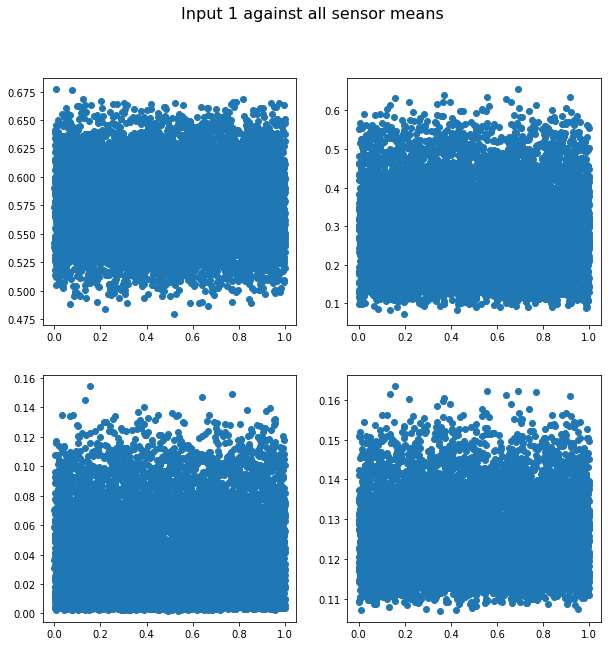

In [ ]:
# calculate correlation coefficients of sensor means (for now for the first 4 variables)
sensor_means=np.array([[train_samples[j,i,:].mean() for i in range(4)] for j in range(len(train_samples))])
#print(np.shape(sensor_means))
#print(np.shape(train_labels))
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(train_labels[:,0], sensor_means[:,0])
ax[0,1].scatter(train_labels[:,0], sensor_means[:,1])
ax[1,0].scatter(train_labels[:,0], sensor_means[:,2])
ax[1,1].scatter(train_labels[:,0], sensor_means[:,3])
fig.suptitle('Input 1 against all sensor means', fontsize=16);

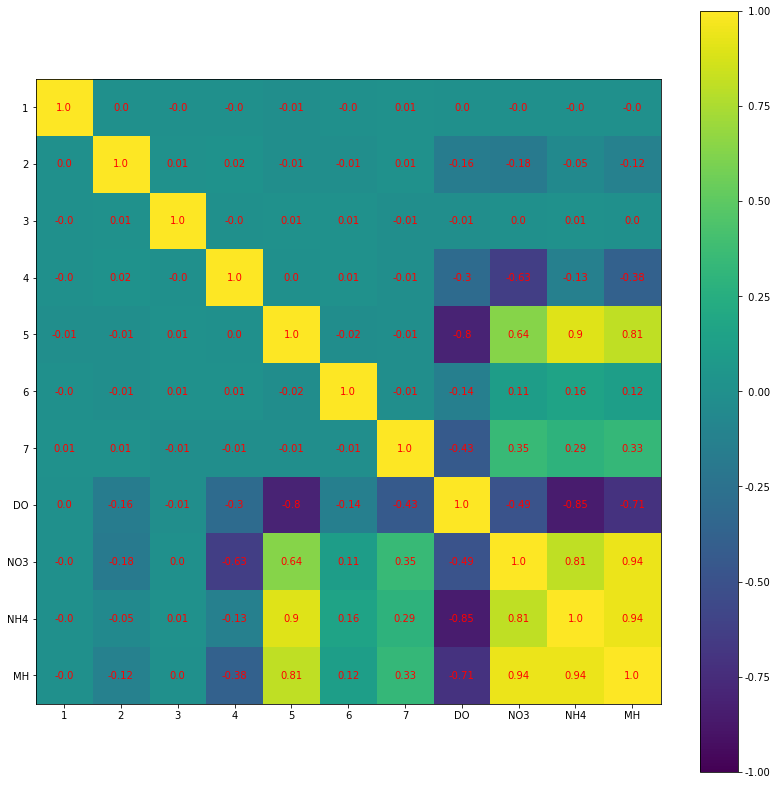

In [ ]:
# plotting the Pearson Correlation to Sensor Means
corr_matrix= np.corrcoef(np.concatenate((train_labels, sensor_means), axis=1), rowvar=False).round(2)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
#ax.set_xlim(-0.5, 10.5)
#ax.set_ylim(-0.5, 10.5)
for i in range(11):
    for j in range(11):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

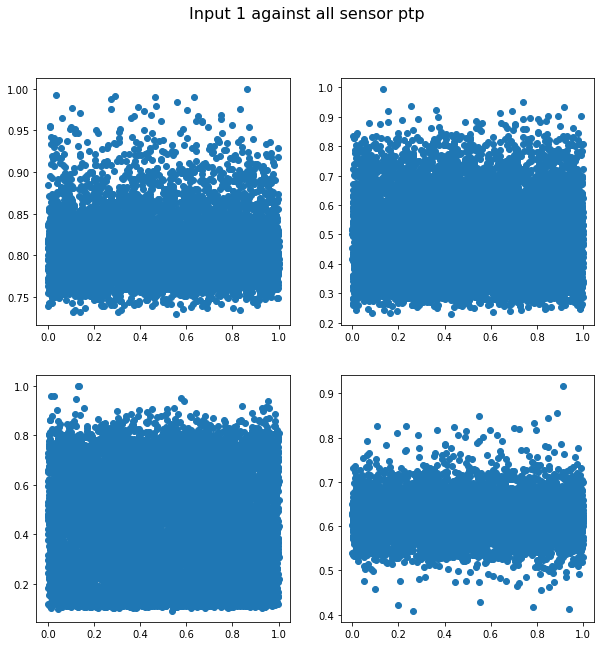

In [ ]:
# calculate correlation coefficients (for now for the first 4 variables)
sensor_ptp = np.array([[train_samples[j,i,:].ptp() for i in range(4)] for j in range(len(train_samples))])

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(train_labels[:, 0], sensor_ptp[:, 0])
ax[0,1].scatter(train_labels[:, 0], sensor_ptp[:, 1])
ax[1,0].scatter(train_labels[:, 0], sensor_ptp[:, 2])
ax[1,1].scatter(train_labels[:, 0], sensor_ptp[:, 3])
fig.suptitle('Input 1 against all sensor ptp', fontsize=16);

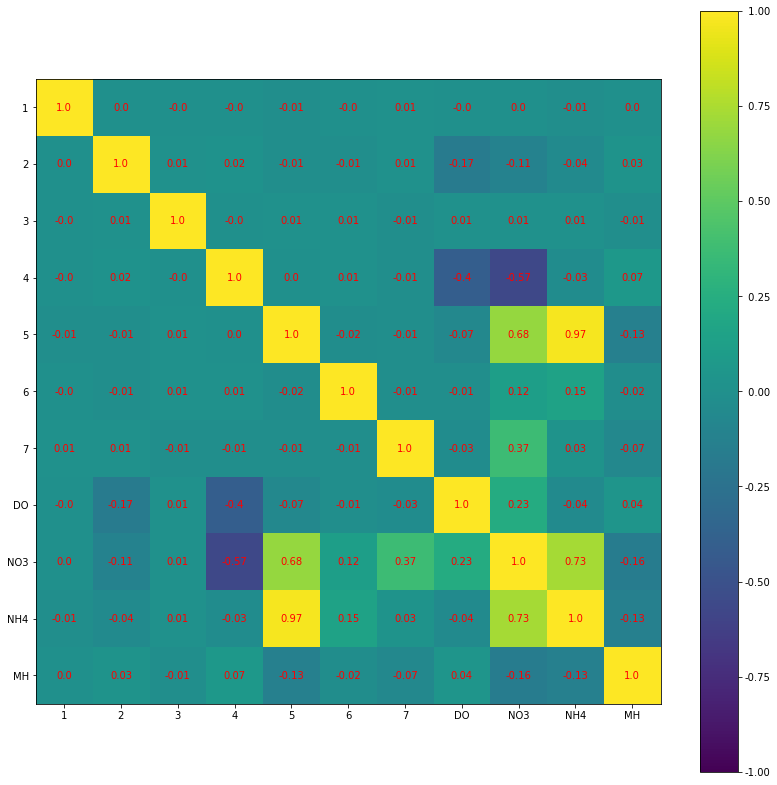

In [ ]:
# plotting the Pearson Correlation to Sensor PTP
corr_matrix= np.corrcoef(np.concatenate((train_labels, sensor_ptp), axis=1), rowvar=False).round(2)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
#ax.set_xlim(-0.5, 10.5)
#ax.set_ylim(-0.5, 10.5)
for i in range(11):
    for j in range(11):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

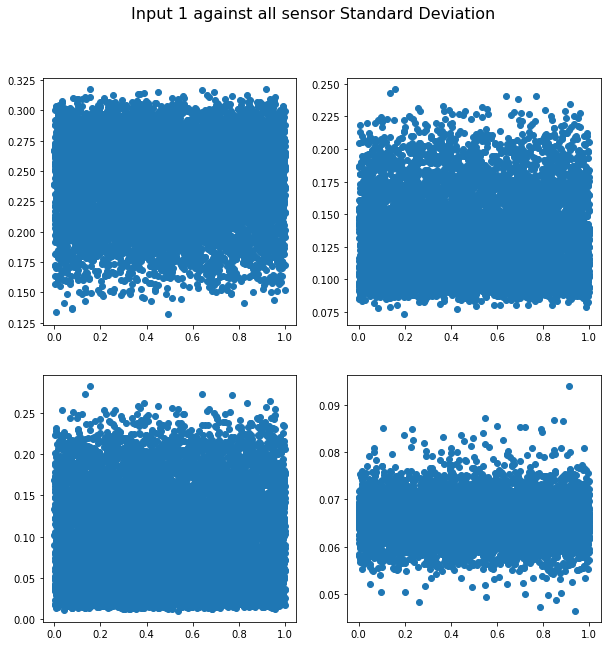

In [ ]:
# calculate correlation coefficients of sensor means (for now for the first 4 variables)
sensor_std = np.array([[train_samples[j,i,:].std() for i in range(4)] for j in range(len(train_samples))])
#print(np.shape(sensor_means))
#print(np.shape(train_labels))
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(train_labels[:,0], sensor_std[:,0])
ax[0,1].scatter(train_labels[:,0], sensor_std[:,1])
ax[1,0].scatter(train_labels[:,0], sensor_std[:,2])
ax[1,1].scatter(train_labels[:,0], sensor_std[:,3])
fig.suptitle('Input 1 against all sensor Standard Deviation', fontsize=16);

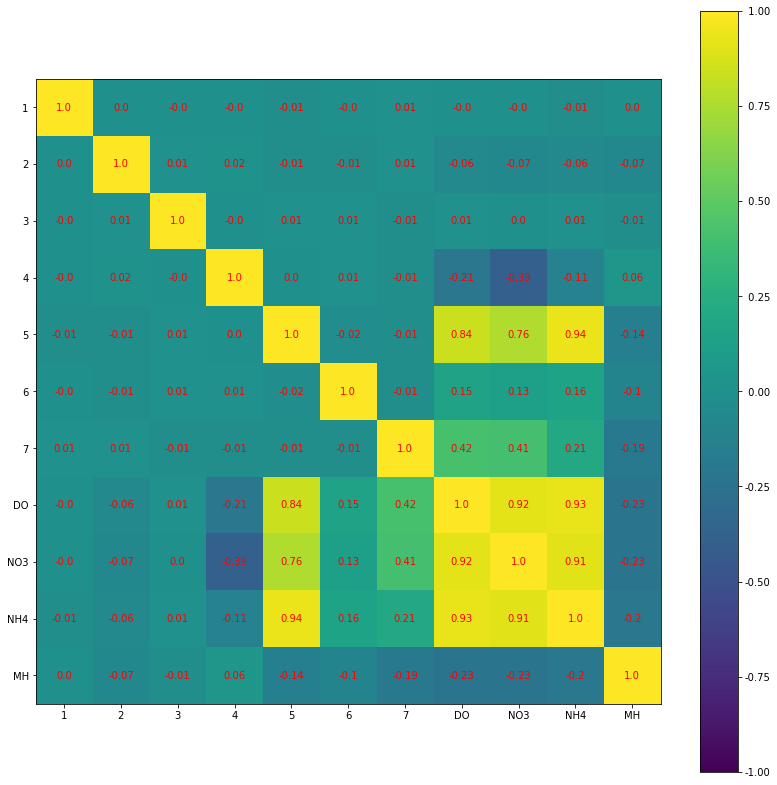

In [ ]:
# plotting the Pearson Correlation to Sensor STD
corr_matrix= np.corrcoef(np.concatenate((train_labels, sensor_std), axis=1), rowvar=False).round(2)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), ticklabels=('1', '2', '3', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
#ax.set_xlim(-0.5, 10.5)
#ax.set_ylim(-0.5, 10.5)
for i in range(11):
    for j in range(11):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

In [ ]:
# creating an alternative label matrix with only the correlated variables
indexes = [1,3,4,5,6]
short_train_labels = train_labels[:,indexes]
short_test_labels = test_labels[:,indexes]
print(np.shape(short_train_labels))

(9001, 5)


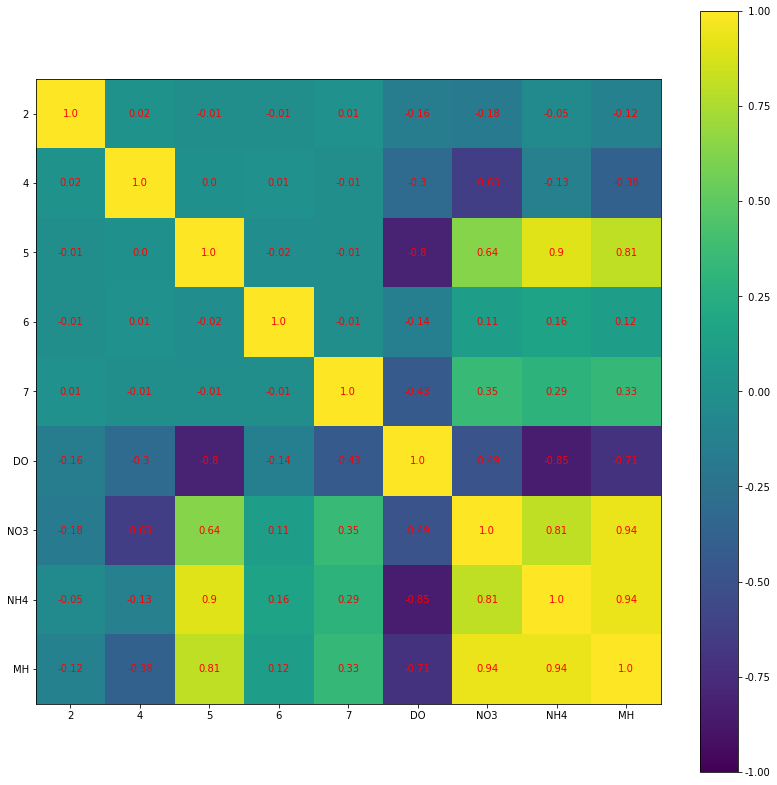

In [ ]:
# confirming the right columns were removed
corr_matrix= np.corrcoef(np.concatenate((short_train_labels, sensor_means), axis=1), rowvar=False).round(2)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8), ticklabels=('2', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
ax.yaxis.set(ticks=(0, 1, 2, 3, 4, 5, 6, 7, 8), ticklabels=('2', '4', '5', '6','7','DO', 'NO3', 'NH4', 'MH'))
#ax.set_xlim(-0.5, 10.5)
#ax.set_ylim(-0.5, 10.5)
for i in range(9):
    for j in range(9):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

# **Model Implementation and Testing**

## **Multi-Layer Perceptron Model**

In [ ]:
# setting up GPU usage
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
# Define Sequential model with 4 layers
model = keras.Sequential( #only hidden layers are defined
    [
        Dense(units=128, input_shape=(384,), activation="relu", name="layer1"),
        Dense(units=32, activation="relu", name="layer2"),
        Dense(units=32, activation="relu", name="layer3"),
        Dense(units=5, activation="relu", name="output"),
    ]
)

# summarize model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               49280     
                                                                 
 layer2 (Dense)              (None, 32)                4128      
                                                                 
 layer3 (Dense)              (None, 32)                1056      
                                                                 
 output (Dense)              (None, 5)                 165       
                                                                 
Total params: 54,629
Trainable params: 54,629
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train neural network
model.compile(optimizer=Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=["mse"])

In [ ]:
flat_train_samples = np.array([train_samples[i,:,:].flatten() for i in range(len(train_samples))])

In [ ]:
# fit model to data
model.fit(x=flat_train_samples, y=short_train_labels, validation_split=0.1, batch_size=100, epochs=200, shuffle=True, verbose=1)#verbose is how much output we get

Epoch 1/200
81/81 [==============================] - 1s 4ms/step - loss: 0.1691 - mse: 0.1691 - val_loss: 0.1126 - val_mse: 0.1126
Epoch 2/200
81/81 [==============================] - 0s 3ms/step - loss: 0.1054 - mse: 0.1054 - val_loss: 0.1021 - val_mse: 0.1021
Epoch 3/200
81/81 [==============================] - 0s 3ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.0983 - val_mse: 0.0983
Epoch 4/200
81/81 [==============================] - 0s 3ms/step - loss: 0.1001 - mse: 0.1001 - val_loss: 0.1022 - val_mse: 0.1022
Epoch 5/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0989 - mse: 0.0989 - val_loss: 0.0966 - val_mse: 0.0966
Epoch 6/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0977 - mse: 0.0977 - val_loss: 0.0931 - val_mse: 0.0931
Epoch 7/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 8/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0915 - m

In [ ]:
flattened_test_samples = np.array([test_samples[i,:,:].flatten() for i in range(len(test_samples))])
predictions = model.predict(x=flattened_test_samples, batch_size=10, verbose=0)
#print(predictions)

In [ ]:
#calculate testing explained variance
explained_variance_score(short_test_labels, predictions)

0.8990289664628524

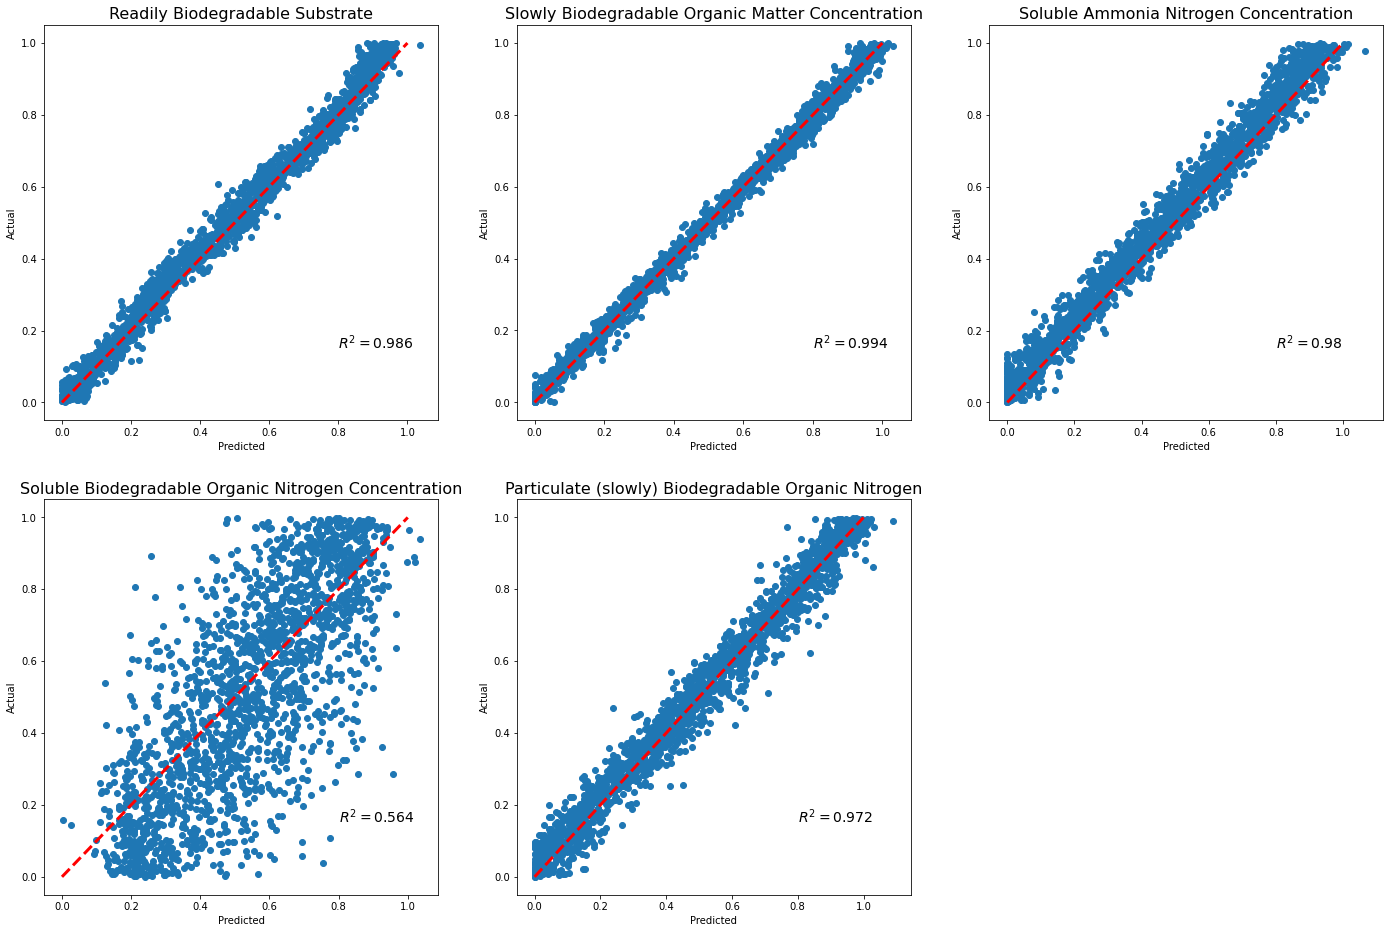

In [ ]:
#Pearson Correlation
corr_matrix= np.corrcoef(y=short_test_labels, x=predictions, rowvar=False).round(4)

fig = plt.figure(figsize=(24, 16))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax1.scatter(predictions[:,0], short_test_labels[:,0])
ax1.plot([0,1], [0,1], 'r--', lw=3)
ax1.set_title('Readily Biodegradable Substrate', fontsize=16)
ax1.text(0.8,0.15,f"$R^2 = {(corr_matrix[5,0]**2).round(3)}$", fontsize=14)
ax1.set(xlabel="Predicted", ylabel="Actual")

ax2.scatter(predictions[:,1], short_test_labels[:,1])
ax2.plot([0,1], [0,1], 'r--', lw=3)
ax2.set_title('Slowly Biodegradable Organic Matter Concentration', fontsize=16)
ax2.text(0.8,0.15,f"$R^2 = {(corr_matrix[6,1]**2).round(3)}$", fontsize=14)
ax2.set(xlabel="Predicted", ylabel="Actual")

ax3.scatter(predictions[:,2], short_test_labels[:,2])
ax3.plot([0,1], [0,1], 'r--', lw=3)
ax3.set_title('Soluble Ammonia Nitrogen Concentration', fontsize=16)
ax3.text(0.8,0.15,f"$R^2 = {(corr_matrix[7,2]**2).round(3)}$", fontsize=14)
ax3.set(xlabel="Predicted", ylabel="Actual")

ax4.scatter(predictions[:,3], short_test_labels[:,3])
ax4.plot([0,1], [0,1], 'r--', lw=3)
ax4.set_title('Soluble Biodegradable Organic Nitrogen Concentration', fontsize=16)
ax4.text(0.8,0.15,f"$R^2 = {(corr_matrix[8,3]**2).round(3)}$", fontsize=14)
ax4.set(xlabel="Predicted", ylabel="Actual")

ax5.scatter(predictions[:,4], short_test_labels[:,4])
ax5.plot([0,1], [0,1], 'r--', lw=3)
ax5.set_title('Particulate (slowly) Biodegradable Organic Nitrogen', fontsize=16)
ax5.text(0.8,0.15,f"$R^2 = {(corr_matrix[9,4]**2).round(3)}$", fontsize=14)
ax5.set(xlabel="Predicted", ylabel="Actual");

In [ ]:
#if os.path.isfile('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/MLP_model.h5') is False:
print("Saving the current model as \"MLP_model.h5\": ")
model.summary()
model.save('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/MLP_model.h5')

Saving the current model as "MLP_model.h5": 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               49280     
                                                                 
 layer2 (Dense)              (None, 32)                4128      
                                                                 
 layer3 (Dense)              (None, 32)                1056      
                                                                 
 output (Dense)              (None, 5)                 165       
                                                                 
Total params: 54,629
Trainable params: 54,629
Non-trainable params: 0
_________________________________________________________________


## **2D - Convolutional Neural Network Model**

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


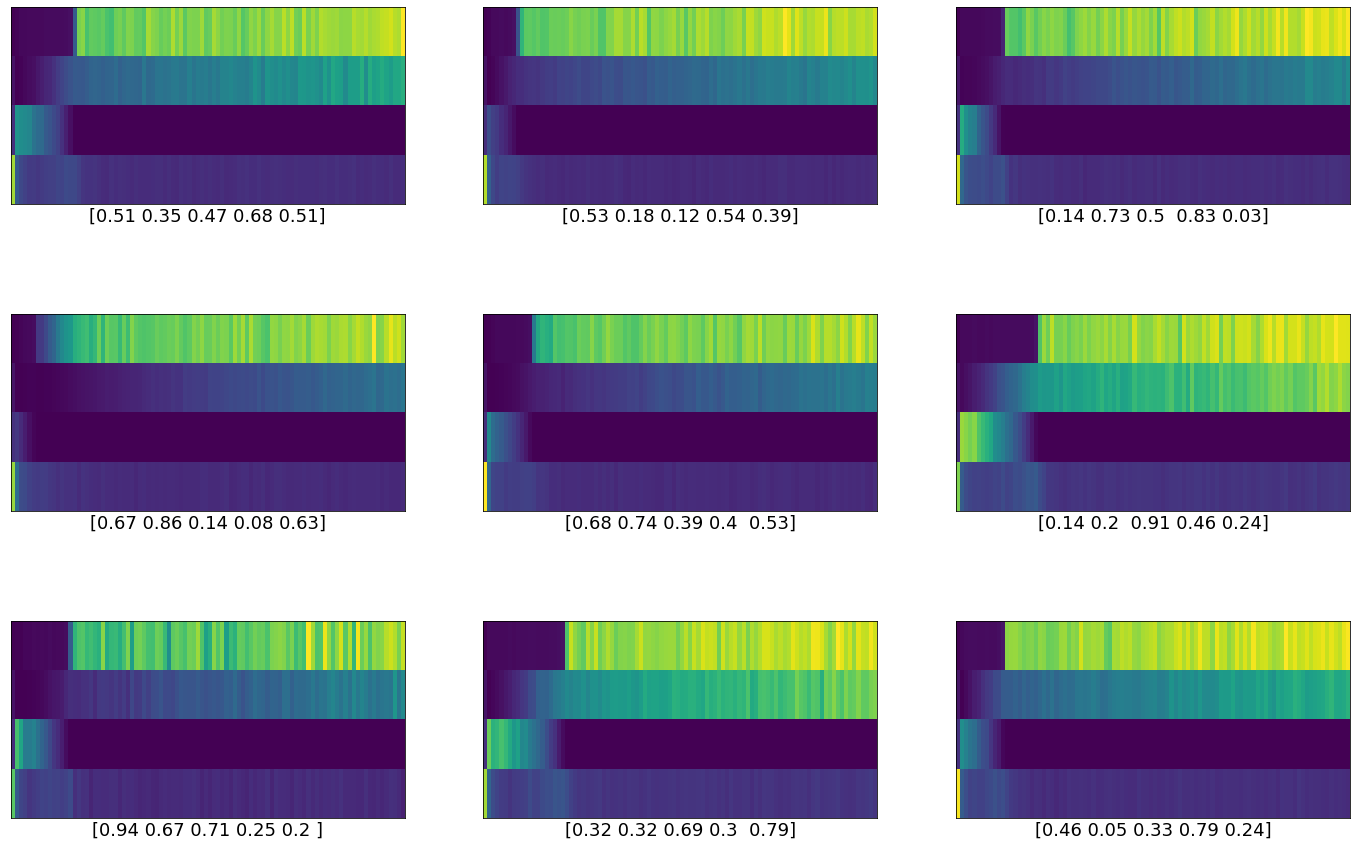

In [ ]:
# show data as image
#plt.imshow(train_samples[0], extent=(0,8,0,4));

plt.figure(figsize=(24,16));
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_samples[i], extent=(0,8,0,4))
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(short_train_labels[i].round(2), fontsize=18)
plt.show();

In [ ]:
# Define a 2D Convolution model with layers
cnn_model = keras.Sequential()#only hidden layers are defined
cnn_model.add(Conv2D(32, (4, 4), strides=(2,2), activation='relu', input_shape=(4, 96,1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation="relu"))
cnn_model.add(Dense(units=32, activation='relu'))
cnn_model.add(Dense(units=5, activation='relu'))

# summarize model
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1, 47, 32)         544       
                                                                 
 flatten_6 (Flatten)         (None, 1504)              0         
                                                                 
 dense_20 (Dense)            (None, 32)                48160     
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 5)                 165       
                                                                 
Total params: 49,925
Trainable params: 49,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train neural network
cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError())

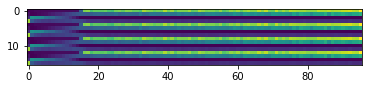

In [ ]:
np.shape(np.concatenate((train_samples, train_samples, train_samples, train_samples), axis=1))
plt.imshow(np.concatenate((train_samples, train_samples, train_samples, train_samples), axis=1)[0])

In [ ]:
# fit model to data
cnn_model.fit(x=train_samples, y=short_train_labels, validation_split=0.1, batch_size=100, epochs=200, shuffle=True, verbose=1)#verbose is how much output we get

Epoch 1/200
81/81 [==============================] - 1s 4ms/step - loss: 0.0729 - val_loss: 0.0498
Epoch 2/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.0340
Epoch 3/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0335
Epoch 4/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0342
Epoch 5/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0341
Epoch 6/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0327
Epoch 7/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0316
Epoch 8/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0262
Epoch 9/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0235
Epoch 10/200
81/81 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 11/

In [ ]:
# testing
%time
cnn_predictions = cnn_model.predict(x=test_samples, batch_size=10, verbose=0)
#print(np.min(predictions))
#print(np.max(predictions))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [ ]:
#calculate testing explained variance
explained_variance_score(short_test_labels, cnn_predictions)

0.8950548556880193

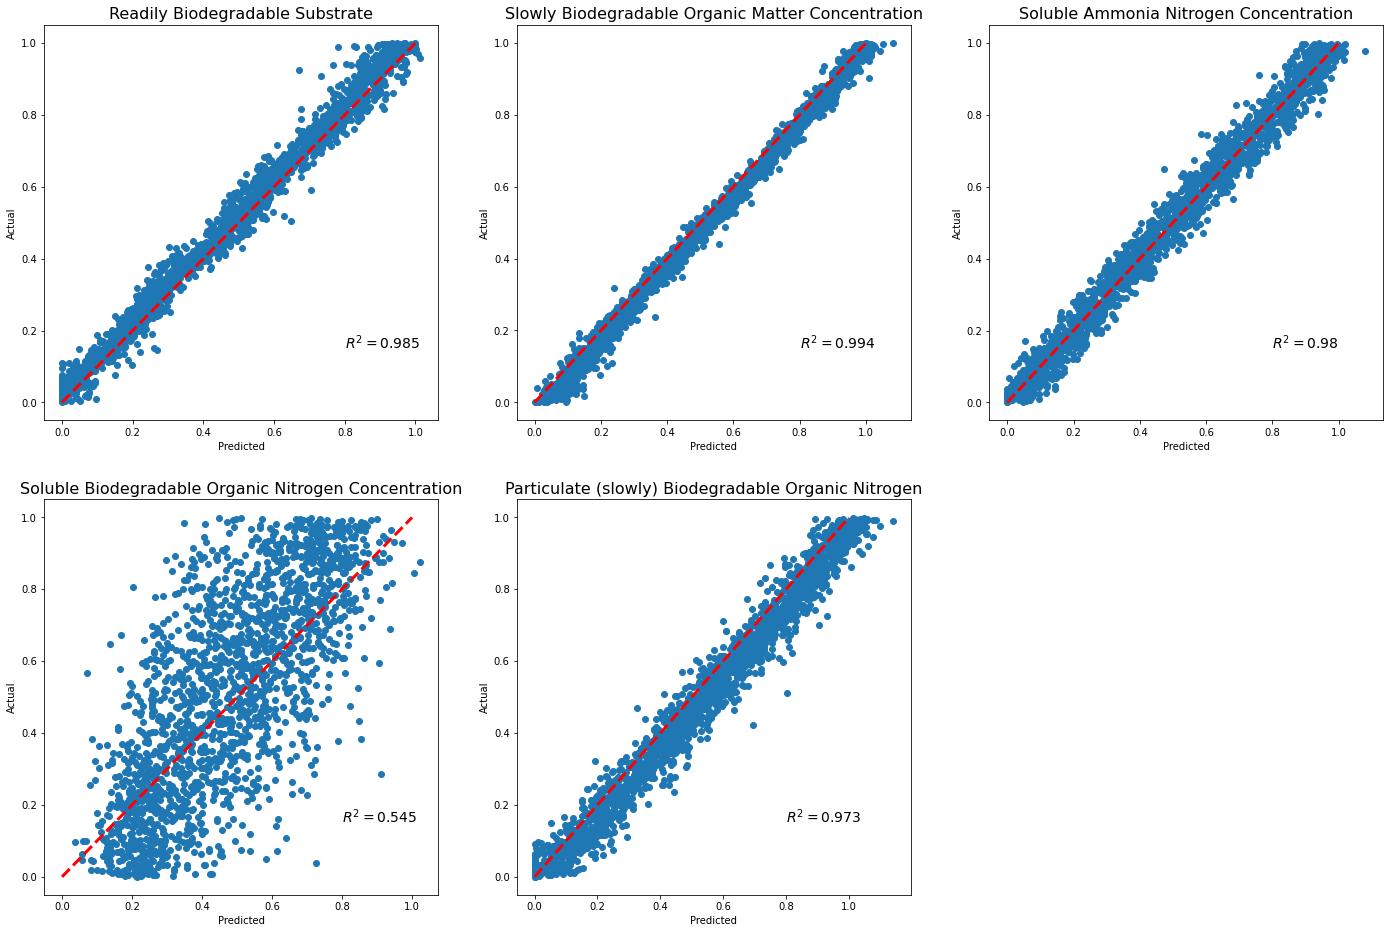

In [ ]:
#Pearson Correlation
corr_matrix= np.corrcoef(y=short_test_labels, x=cnn_predictions, rowvar=False).round(4)

fig = plt.figure(figsize=(24, 16))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax1.scatter(cnn_predictions[:,0], short_test_labels[:,0])
ax1.plot([0,1], [0,1], 'r--', lw=3)
ax1.set_title('Readily Biodegradable Substrate', fontsize=16)
ax1.text(0.8,0.15,f"$R^2 = {(corr_matrix[5,0]**2).round(3)}$", fontsize=14)
ax1.set(xlabel="Predicted", ylabel="Actual")

ax2.scatter(cnn_predictions[:,1], short_test_labels[:,1])
ax2.plot([0,1], [0,1], 'r--', lw=3)
ax2.set_title('Slowly Biodegradable Organic Matter Concentration', fontsize=16)
ax2.text(0.8,0.15,f"$R^2 = {(corr_matrix[6,1]**2).round(3)}$", fontsize=14)
ax2.set(xlabel="Predicted", ylabel="Actual")

ax3.scatter(cnn_predictions[:,2], short_test_labels[:,2])
ax3.plot([0,1], [0,1], 'r--', lw=3)
ax3.set_title('Soluble Ammonia Nitrogen Concentration', fontsize=16)
ax3.text(0.8,0.15,f"$R^2 = {(corr_matrix[7,2]**2).round(3)}$", fontsize=14)
ax3.set(xlabel="Predicted", ylabel="Actual")

ax4.scatter(cnn_predictions[:,3], short_test_labels[:,3])
ax4.plot([0,1], [0,1], 'r--', lw=3)
ax4.set_title('Soluble Biodegradable Organic Nitrogen Concentration', fontsize=16)
ax4.text(0.8,0.15,f"$R^2 = {(corr_matrix[8,3]**2).round(3)}$", fontsize=14)
ax4.set(xlabel="Predicted", ylabel="Actual")

ax5.scatter(cnn_predictions[:,4], short_test_labels[:,4])
ax5.plot([0,1], [0,1], 'r--', lw=3)
ax5.set_title('Particulate (slowly) Biodegradable Organic Nitrogen', fontsize=16)
ax5.text(0.8,0.15,f"$R^2 = {(corr_matrix[9,4]**2).round(3)}$", fontsize=14)
ax5.set(xlabel="Predicted", ylabel="Actual");

In [ ]:
#if os.path.isfile('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/CNN_model.h5') is False:
print("Saving the current model as \"CNN_model.h5\": ")
cnn_model.summary()
cnn_model.save('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/CNN_model.h5')

Saving the current model as "CNN_model.h5": 
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1, 47, 32)         544       
                                                                 
 flatten_6 (Flatten)         (None, 1504)              0         
                                                                 
 dense_20 (Dense)            (None, 32)                48160     
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 5)                 165       
                                                                 
Total params: 49,925
Trainable params: 49,925
Non-trainable params: 0
_________________________________________________________________


## **Gated Recursive Unit Model**

In [ ]:
# Define Sequential model with 3 layers
lstm_model = keras.Sequential()
lstm_model.add(GRU(128, activation='relu', input_shape=(96,4)))
#lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(5, activation='relu'))

lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 128)               51456     
                                                                 
 dense_42 (Dense)            (None, 32)                4128      
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 55,749
Trainable params: 55,749
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train neural network
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss=tf.keras.losses.MeanAbsoluteError())

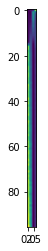

In [ ]:
reshaped_train_samples = np.zeros((len(train_samples), 96, 4))
for i in range(len(train_samples)):
  reshaped_train_samples[i] = train_samples[i].T

plt.imshow(reshaped_train_samples[0])

In [ ]:
# fit model to data
lstm_model.fit(x=reshaped_train_samples, y=short_train_labels, validation_split=0.1, batch_size=100, epochs=100, shuffle=True, verbose=1)#verbose is how much output we get

Epoch 1/100
81/81 [==============================] - 5s 53ms/step - loss: 0.3458 - val_loss: 0.3389
Epoch 2/100
81/81 [==============================] - 4s 49ms/step - loss: 0.3347 - val_loss: 0.3325
Epoch 3/100
81/81 [==============================] - 4s 51ms/step - loss: 0.3341 - val_loss: 0.3323
Epoch 4/100
81/81 [==============================] - 4s 50ms/step - loss: 0.3342 - val_loss: 0.3313
Epoch 5/100
81/81 [==============================] - 4s 47ms/step - loss: 0.3332 - val_loss: 0.3313
Epoch 6/100
81/81 [==============================] - 4s 49ms/step - loss: 0.3189 - val_loss: 0.3086
Epoch 7/100
81/81 [==============================] - 4s 49ms/step - loss: 0.3098 - val_loss: 0.3067
Epoch 8/100
81/81 [==============================] - 4s 49ms/step - loss: 0.3080 - val_loss: 0.3042
Epoch 9/100
81/81 [==============================] - 4s 48ms/step - loss: 0.3072 - val_loss: 0.3041
Epoch 10/100
81/81 [==============================] - 4s 47ms/step - loss: 0.3040 - val_loss: 0.2950

In [ ]:
# predicting with the model

reshaped_test_samples = np.zeros((len(test_samples), 96, 4))
for i in range(len(test_samples)):
  reshaped_test_samples[i] = test_samples[i].T

lstm_predictions = lstm_model.predict(x=reshaped_test_samples, verbose=0)

In [ ]:
#calculate testing explained variance
explained_variance_score(short_test_labels, lstm_predictions)

0.8928754536091035

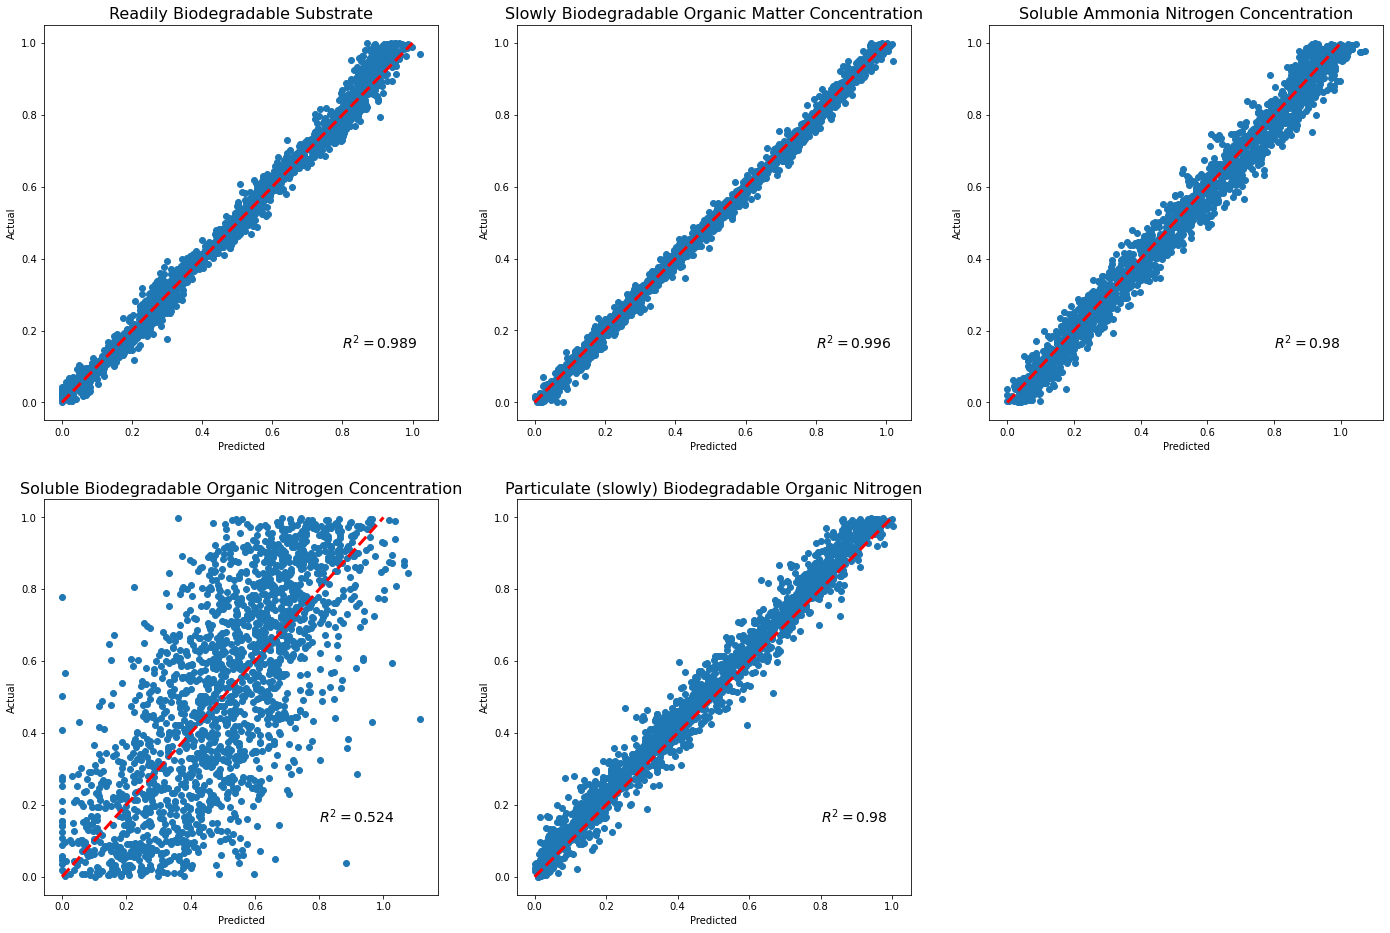

In [ ]:
#Pearson Correlation
corr_matrix= np.corrcoef(y=short_test_labels, x=lstm_predictions, rowvar=False).round(4)

fig = plt.figure(figsize=(24, 16))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax1.scatter(lstm_predictions[:,0], short_test_labels[:,0])
ax1.plot([0,1], [0,1], 'r--', lw=3)
ax1.set_title('Readily Biodegradable Substrate', fontsize=16)
ax1.text(0.8,0.15,f"$R^2 = {(corr_matrix[5,0]**2).round(3)}$", fontsize=14)
ax1.set(xlabel="Predicted", ylabel="Actual")

ax2.scatter(lstm_predictions[:,1], short_test_labels[:,1])
ax2.plot([0,1], [0,1], 'r--', lw=3)
ax2.set_title('Slowly Biodegradable Organic Matter Concentration', fontsize=16)
ax2.text(0.8,0.15,f"$R^2 = {(corr_matrix[6,1]**2).round(3)}$", fontsize=14)
ax2.set(xlabel="Predicted", ylabel="Actual")

ax3.scatter(lstm_predictions[:,2], short_test_labels[:,2])
ax3.plot([0,1], [0,1], 'r--', lw=3)
ax3.set_title('Soluble Ammonia Nitrogen Concentration', fontsize=16)
ax3.text(0.8,0.15,f"$R^2 = {(corr_matrix[7,2]**2).round(3)}$", fontsize=14)
ax3.set(xlabel="Predicted", ylabel="Actual")

ax4.scatter(lstm_predictions[:,3], short_test_labels[:,3])
ax4.plot([0,1], [0,1], 'r--', lw=3)
ax4.set_title('Soluble Biodegradable Organic Nitrogen Concentration', fontsize=16)
ax4.text(0.8,0.15,f"$R^2 = {(corr_matrix[8,3]**2).round(3)}$", fontsize=14)
ax4.set(xlabel="Predicted", ylabel="Actual")

ax5.scatter(lstm_predictions[:,4], short_test_labels[:,4])
ax5.plot([0,1], [0,1], 'r--', lw=3)
ax5.set_title('Particulate (slowly) Biodegradable Organic Nitrogen', fontsize=16)
ax5.text(0.8,0.15,f"$R^2 = {(corr_matrix[9,4]**2).round(3)}$", fontsize=14)
ax5.set(xlabel="Predicted", ylabel="Actual");

In [ ]:
#if os.path.isfile('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/GRU_model.h5') is False:
print("Saving the current model as \"GRU_model.h5\": ")
lstm_model.summary()
lstm_model.save('/content/gdrive/MyDrive/BREE495/DataGeneration/Models/GRU_model.h5')

Saving the current model as "GRU_model.h5": 
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 128)               51456     
                                                                 
 dense_42 (Dense)            (None, 32)                4128      
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 55,749
Trainable params: 55,749
Non-trainable params: 0
_________________________________________________________________


# Extra Graph

In [ ]:
import matplotlib.pyplot as plt

r_squares_MLP = [.986, .994, .98, .]

plt.plot

